# Introduction

### Problem

In the project this week, we will build a machine learning text classifier to predict news categories from the news article text. 
1. We will iterate on classification models with increasing level of complexity and improved performance. 
2. We will look at the impact of training data size on model performance.
3. [advanced] As an extension, you will explore how to augment data efficiently to your existing training data (efficiency measured as improvement in performance normalized by volume of data augmented). The reason to consider efficiency is that in most real-world scenarios, additional data is typically unlabeled. In order to augment it to your training data, you have to get it annotated which incurs some time & money (either yoursself or through one of the existing annotation tools such as Labelbox, Scale etc). 

Throughout the project there are suggested model architectures that we expect to work reasonably well for this problem. But if you wish to extend/modify any part of this pipeline, or explore new model architectures you should definitely feel free to do so.

### Deliverables
1. Train average word vector classifier and report model performance for training size = [500, 1000, 2000, 5000, 10000, 25000]
2. Train transformer encoder classifier and report model performance for training size = [500, 1000, 2000, 5000, 10000, 25000]
3. Report performance improvement on the test dataset from naive dataset augmentation outlined in the this notebook
4. [stretch] Experiment with advanced data augmentation techniques (a few ideas & pointers given in the notebook below)


## Step1: Prereqs & Installation

Download & Import all the necessary libraries we need throughout the project.

In [ ]:
# Install all the required dependencies for the project

!pip install numpy
!pip install scikit-learn
!pip install gensim
!pip install sentence-transformers
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sentence_transformers-2.2.2-py3-none-any.whl
  Using cached transformers-4.20.1-py3-none-any.whl (4.4 MB)
  Using cached sentencepiece-0.1.96-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Package imports that will be needed for this project

import numpy as np
import json
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
from sentence_transformers import SentenceTransformer
from gensim.utils import tokenize as gensim_tokenizer
import gensim.downloader as gensim_downloader
from sklearn.base import BaseEstimator, TransformerMixin
from pprint import pprint
from sklearn.pipeline import Pipeline

# [TO BE IMPLEMENTED] 
# Add any other imports needed below depending on the model architectures you are using. For e.g.
from sklearn.linear_model import LogisticRegression

In [ ]:
# Global Constants
LABEL_SET = [
    'Business',
    'Sci/Tech',
    'Software and Developement',
    'Entertainment',
    'Sports',
    'Health',
    'Toons',
    'Music Feeds'
]

WORD_VECTOR_MODEL = 'glove-wiki-gigaword-100'
SENTENCE_TRANSFORMER_MODEL = 'all-mpnet-base-v2'

TRAIN_SIZE_EVALS = [500, 1000, 2000, 5000, 10000, 25000]
EPS = 0.001
SEED = 0

np.random.seed(SEED)

## Step 2: Download & Load Datasets 

[AG News](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) is a collection of more than 1 million news articles gathered from more than 2000 news sources by an academic news search engine. The news topic classification dataset & benchmark was first used in [Character-level Convolutional Networks for Text Classification (NIPS 2015)](https://arxiv.org/abs/1509.01626). The dataset has the text description (summary) of the news article along with some metadata. **For this project, we will use a slightly modified (cleaned up) version of this dataset** 

Schema:
* Source - News publication source
* URL - URL of the news article
* Title - Title of the news article
* Description - Summary description of the news article
* Category (Label) - News category

Sample row in this dataset:
```
{
    'description': 'A capsule carrying solar material from the Genesis space '
                'probe has made a crash landing at a US Air Force training '
                'facility in the US state of Utah.',
    'id': 86273,
    'label': 'Entertainment',
    'source': 'Voice of America',
    'title': 'Capsule from Genesis Space Probe Crashes in Utah Desert',
    'url': 'http://www.sciencedaily.com/releases/2004/09/040908090621.htm'
 }
```




In [ ]:
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

DIRECTORY_NAME = "data"
DOWNLOAD_URL = 'https://corise-mlops.s3.us-west-2.amazonaws.com/project1/agnews.zip'

def download_dataset():
    """
    Download the dataset. The zip contains three files: train.json, test.json and unlabeled.json 
    """
    http_response = urlopen(DOWNLOAD_URL)
    zipfile = ZipFile(BytesIO(http_response.read()))
    zipfile.extractall(path=DIRECTORY_NAME)

# Expensive operation so we should just do this once
download_dataset()

In [ ]:
Datasets = {}

for ds in ['train', 'test', 'augment']:
    with open('data/{}.json'.format(ds), 'r') as f:
        Datasets[ds] = json.load(f)
    print("Loaded Dataset {0} with {1} rows".format(ds, len(Datasets[ds])))

print("\nExample train row:\n")
pprint(Datasets['train'][0])

print("\nExample test row:\n")
pprint(Datasets['test'][0])

Loaded Dataset train with 25000 rows
Loaded Dataset test with 50000 rows
Loaded Dataset augment with 150000 rows

Example train row:

{'description': 'A capsule carrying solar material from the Genesis space '
                'probe has made a crash landing at a US Air Force training '
                'facility in the US state of Utah.',
 'id': 86273,
 'label': 'Entertainment',
 'source': 'Voice of America',
 'title': 'Capsule from Genesis Space Probe Crashes in Utah Desert',
 'url': 'http://www.sciencedaily.com/releases/2004/09/040908090621.htm'}

Example test row:

{'description': 'AP - Ellis L. Marsalis Sr., the patriarch of a family of '
                'world famous jazz musicians, including grandson Wynton '
                'Marsalis, has died. He was 96.',
 'id': 143852,
 'label': 'Entertainment',
 'source': 'Yahoo Entertainment',
 'title': 'Music Patriarch Marsalis Sr. Dies (AP)',
 'url': 'http://us.rd.yahoo.com/dailynews/rss/entertainment/*http://story.news.yahoo.com/news?tmpl

In [ ]:
X_train, Y_train = [], []
X_test, Y_true = [], []
X_augment, Y_augment = [], []

for row in Datasets['train']:
    X_train.append(row['description'])
    Y_train.append(row['label'])

for row in Datasets['test']:
    X_test.append(row['description'])
    Y_true.append(row['label'])

for row in Datasets['augment']:
    X_augment.append(row['description'])
    Y_augment.append(row['label'])

## Step 3: [Modeling part 1] Word vectors

In [ ]:
# Initialize the word vector model
word_vector_model = gensim_downloader.load(WORD_VECTOR_MODEL)

# Sanity check
print(word_vector_model.most_similar("cat"))
print(word_vector_model['cat'])

[==================================================] 100.0% 128.1/128.1MB downloaded
[('dog', 0.8798074722290039), ('rabbit', 0.7424426674842834), ('cats', 0.7323004007339478), ('monkey', 0.7288709878921509), ('pet', 0.7190139889717102), ('dogs', 0.7163872718811035), ('mouse', 0.6915250420570374), ('puppy', 0.6800068020820618), ('rat', 0.6641027331352234), ('spider', 0.6501135230064392)]
[ 0.23088    0.28283    0.6318    -0.59411   -0.58599    0.63255
  0.24402   -0.14108    0.060815  -0.7898    -0.29102    0.14287
  0.72274    0.20428    0.1407     0.98757    0.52533    0.097456
  0.8822     0.51221    0.40204    0.21169   -0.013109  -0.71616
  0.55387    1.1452    -0.88044   -0.50216   -0.22814    0.023885
  0.1072     0.083739   0.55015    0.58479    0.75816    0.45706
 -0.28001    0.25225    0.68965   -0.60972    0.19578    0.044209
 -0.31136   -0.68826   -0.22721    0.46185   -0.77162    0.10208
  0.55636    0.067417  -0.57207    0.23735    0.4717     0.82765
 -0.29263   -1.3422  

In [ ]:
class WordVectorFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, dim, word_vector_model):
        self.dim = dim
        self.word_vector_model = word_vector_model
        # you can add any other params to be passed to the constructor here
    
    #estimator. Since we don't have to learn anything in the featurizer, this is a no-op
    def fit(self, X, y=None):
        return self
    
    #transformation: return the average word vector of each token in the document
    def transform(self, X, y=None):
        """
        [TO BE IMPLEMENTED]
        
        Goal: WordVectorFeaturizer's transform() method converts the raw text document
        into a feature vector to be passed as input to the classifier.
            
        Given below is a dummy implementation that always maps it to a zero vector.
        You have to implement this function so it does two things:
            (1) Convert the raw text document into a list of tokens
            (2) Map each token to a word vector (using self.word_vector_model)
            (3) Return the mean vector of the sequence of word vectors
        This will be our feature representation of the document
        """

        X_t = []
        for doc in X:
          doc = list(gensim_tokenizer(doc, lowercase=True, deacc=True))
          element_array = [word_vector_model[doc_element] for doc_element in doc if doc_element in word_vector_model]
          if len(element_array) == 0:
            X_t.append(np.zeros(self.dim))
          else:
            X_t.append(np.mean(element_array, axis=0))
        return X_t

In [ ]:
X_train_vectorized = WordVectorFeaturizer(100, word_vector_model).transform(X_train)
X_test_vectorized = WordVectorFeaturizer(100, word_vector_model).transform(X_test)

In [ ]:
import warnings
warnings.filterwarnings("ignore")
models = {}


for n in TRAIN_SIZE_EVALS:
    print("Evaluating for training data size = {}".format(n))
    X_train_i = X_train_vectorized[:n]
    Y_train_i = Y_train[:n]

    """
    [TO BE IMPLEMENTED]
        
    Goal: initialized below is a dummy sklearn Pipeline object with no steps.
    You have to replace it with a pipeline object which contains at least two steps:
    (1) mapping the input document to a feature vector (using WordVectorFeaturizer)
    (2) a classifier that predicts the class label using the feature output of first step

    You can add other steps to preproces, post-process your data as you see fit. 
    You can also try any sklearn model architecture you want, but a linear classifier
    will do just fine to start with

    e.g. 
    pipeline = Pipeline([
        ('featurizer', <your WordVectorFeaturizer class instance here>),
        ('classifier', <your sklearn classifier class instance here>)
    ])
    """
    pipeline = Pipeline([
        ('classifier', LogisticRegression())
    ])
    
    # train
    pipeline.fit(X_train_i, Y_train_i)
    # predict
    Y_pred_i = pipeline.predict(X_test_vectorized)
    # record results
    models[n] = {
        'pipeline': pipeline,
        'test_predictions': Y_pred_i,
        'accuracy': accuracy_score(Y_true, Y_pred_i),
        'f1': f1_score(Y_true, Y_pred_i, average='weighted'),
        'errors': sum([x != y for (x, y) in zip(Y_true, Y_pred_i)])
    }
    print("Accuracy on test set: {}".format(accuracy_score(Y_true, Y_pred_i)))

Evaluating for training data size = 500
Accuracy on test set: 0.71226
Evaluating for training data size = 1000
Accuracy on test set: 0.72694
Evaluating for training data size = 2000
Accuracy on test set: 0.73686
Evaluating for training data size = 5000
Accuracy on test set: 0.74576
Evaluating for training data size = 10000
Accuracy on test set: 0.7503
Evaluating for training data size = 25000
Accuracy on test set: 0.75274


## Step 4: [Modeling part 2] Pretrained Transformers

In [ ]:
# Initialize the pretrained transformer model
sentence_transformer_model = SentenceTransformer(
    'sentence-transformers/{model}'.format(model=SENTENCE_TRANSFORMER_MODEL))

# Sanity check
example_encoding = sentence_transformer_model.encode(
    "This is an example sentence",
    normalize_embeddings=True
)

print(example_encoding)


Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

[ 2.25026067e-02 -7.82916993e-02 -2.30307374e-02 -5.10005234e-03
 -8.03404450e-02  3.91321443e-02  1.13428682e-02  3.46486829e-03
 -2.94574779e-02 -1.88930184e-02  9.47434008e-02  2.92748138e-02
  3.94859724e-02 -4.63166274e-02  2.54246294e-02 -3.21999677e-02
  6.21928312e-02  1.55591443e-02 -4.67795357e-02  5.03901765e-02
  1.46114035e-02  2.31413692e-02  1.22067155e-02  2.50696354e-02
  2.93657626e-03 -4.19821963e-02 -4.01039375e-03 -2.27843802e-02
 -7.68590020e-03 -3.31090800e-02  3.22118066e-02 -2.09992360e-02
  1.16730686e-02 -9.85073596e-02  1.77932600e-06 -2.29931716e-02
 -1.31141003e-02 -2.80222632e-02 -6.99970350e-02  2.59314124e-02
 -2.89501660e-02  8.76336098e-02 -1.20919039e-02  3.98605429e-02
 -3.31381783e-02  3.59108187e-02  3.46099362e-02  6.49784431e-02
 -3.00817229e-02  6.98188022e-02 -3.99512798e-03 -1.01600494e-03
 -3.50185148e-02 -4.36567031e-02  5.08025624e-02  4.68758009e-02
  5.39663360e-02 -4.03008275e-02  3.20138526e-03  1.36617981e-02
  3.82188708e-02 -3.23846

In [ ]:
class TransformerFeaturizer(BaseEstimator, TransformerMixin):
    def __init__(self, dim, sentence_transformer_model):
        self.dim = dim
        self.sentence_transformer_model = sentence_transformer_model
        # you can add any other params to be passed to the constructor here

    #estimator. Since we don't have to learn anything in the featurizer, this is a no-op
    def fit(self, X, y=None):
        return self

    #transformation: return the encoding of the document as returned by the transformer model 
    def transform(self, X, y=None):
        X_t = []
        """
        [TO BE IMPLEMENTED]
        
        Goal: TransformerFeaturizer's transform() method converts the raw text document
        into a feature vector to be passed as input to the classifier.
            
        Given below is a dummy implementation that always maps it to a zero vector.
        You have to implement this function so it uses computes a document embedding
        of the input document using self.sentence_transformer_model. 
        This will be our feature representation of the document
        """
        for doc in X:
            # TODO: replace this dummy implementation
            X_t.append(self.sentence_transformer_model.encode(
                doc,
                normalize_embeddings=True
            ))
        return X_t

In [ ]:
X_train_vectorized = TransformerFeaturizer(None, sentence_transformer_model).transform(X_train)
X_test_vectorized = TransformerFeaturizer(None, sentence_transformer_model).transform(X_test)

In [ ]:
models_v2 = {}

for n in TRAIN_SIZE_EVALS:
    print("Evaluating for training data size = {}".format(n))
    X_train_i = X_train_vectorized[:n]
    Y_train_i = Y_train[:n]

    """
    [TO BE IMPLEMENTED]
        
    Goal: initialized below is a dummy sklearn Pipeline object with no steps.
    You have to replace it with a pipeline object which contains at least two steps:
    (1) mapping the input document to a feature vector (using TransformerFeaturizer)
    (2) a classifier that predicts the class label using the feature output of first step

    You can add other steps to preproces, post-process your data as you see fit. 
    You can also try any sklearn model architecture you want, but a linear classifier
    will do just fine to start with

    e.g. 
    pipeline = Pipeline([
        ('featurizer', <your TransformerFeaturizer class instance here>),
        ('classifier', <your sklearn classifier class instance here>)
    ])
    """
    pipeline = Pipeline([
        ('classifier', LogisticRegression())
    ])

    # train
    pipeline.fit(X_train_i, Y_train_i)
    # predict
    Y_pred_i = pipeline.predict(X_test_vectorized)
    # record results
    models_v2[n] = {
        'pipeline': pipeline,
        'test_predictions': Y_pred_i,
        'accuracy': accuracy_score(Y_true, Y_pred_i),
        'f1': f1_score(Y_true, Y_pred_i, average='weighted'),
        'errors': sum([x != y for (x, y) in zip(Y_true, Y_pred_i)])
    }
    print("Accuracy on test set: {}".format(accuracy_score(Y_true, Y_pred_i)))


Evaluating for training data size = 500
Accuracy on test set: 0.7246
Evaluating for training data size = 1000
Accuracy on test set: 0.74586
Evaluating for training data size = 2000
Accuracy on test set: 0.76068
Evaluating for training data size = 5000
Accuracy on test set: 0.77608
Evaluating for training data size = 10000
Accuracy on test set: 0.78234
Evaluating for training data size = 25000
Accuracy on test set: 0.78964


## Step 5: Report Results from previous two steps

In [ ]:
# Report results

print("Word Vector Models: ")
for train_size, result in models.items():
    print("Train size: {}  |  Accuracy: {}  |  F1 score: {} |  Num errors: {}".format(
        train_size,
        result['accuracy'],
        result['f1'],
        result['errors']
    ))

print("Pretrained Transformer Models: ")
for train_size, result in models_v2.items():
    print("Train size: {}  |  Accuracy: {}  |  F1 score: {} |  Num errors: {}".format(
        train_size,
        result['accuracy'],
        result['f1'],
        result['errors']
    ))

Word Vector Models: 
Train size: 500  |  Accuracy: 0.71226  |  F1 score: 0.7073686468379936 |  Num errors: 14387
Train size: 1000  |  Accuracy: 0.72694  |  F1 score: 0.7207984998317425 |  Num errors: 13653
Train size: 2000  |  Accuracy: 0.73686  |  F1 score: 0.7313847575524624 |  Num errors: 13157
Train size: 5000  |  Accuracy: 0.74576  |  F1 score: 0.7414484789905316 |  Num errors: 12712
Train size: 10000  |  Accuracy: 0.7503  |  F1 score: 0.7461294127796578 |  Num errors: 12485
Train size: 25000  |  Accuracy: 0.75274  |  F1 score: 0.7483787965589375 |  Num errors: 12363
Pretrained Transformer Models: 
Train size: 500  |  Accuracy: 0.7246  |  F1 score: 0.7147496655624666 |  Num errors: 13770
Train size: 1000  |  Accuracy: 0.74586  |  F1 score: 0.7374798976544422 |  Num errors: 12707
Train size: 2000  |  Accuracy: 0.76068  |  F1 score: 0.752277187806759 |  Num errors: 11966
Train size: 5000  |  Accuracy: 0.77608  |  F1 score: 0.7696193694789849 |  Num errors: 11196
Train size: 10000  |

## Step 6: Data Augmentation

In this section, we want to explore how to augment data efficiently to your existing training data. This is a very empirical exercise with a less well-defined playbook which means this section of the project is going to be open ended. Let us first understand what we mean by efficiency here, and why it matters:

### Performance Gain (G):
We will measure performance gain from data augmentation as the improvement in model accuracy (reduction in num. errors) on the Test dataset as defined above. 

### Budget (K):
We will measure "budget" as the number of additional rows augmentated to the original training dataset.  In this project, the universe of data from which you will select to add to your training set is Datasets['augment'] (and downstream X_augment, Y_augment).

This data is already labeled of course, but in most real-world scenarios the additional data is typically unlabeled. In order to augment it to your training data, you have to get it annotated which incurs some cost in time & money. This is the motivation to consider budget as a metric.

### Efficiency (E = G / K): 
Efficiency = Performance Gain (Reduction in num errors in test set) / Budget (Number of additional rows augmented to the training dataset)

We want to get the maximum gain in performance, while incurring minimum annotation cost.

In [ ]:
X_augment_vectorized = TransformerFeaturizer(None, sentence_transformer_model).transform(X_augment)

In [ ]:
# Naively augmenting data by selecting (and incurring annotation cost) for K examples at random.

# In the code snippet below, we show the gain in performance from augmenting data naively
# at a few different budget values (K = 1000, 5000, 10000, 50000)

models_aug = {}

for K in [1000, 5000, 10000, 50000]:
    print("Evaluating for training data size = {}".format(K))
    X_train_aug = X_train_vectorized + X_augment_vectorized[:K]
    Y_train_aug = Y_train + Y_augment[:K]

    """
    [TO BE IMPLEMENTED]
        
    Paste your pipeline created from Steps 3 or 4 here.
    (You can try both of them out to see what the performance gain is if any)

    e.g. 
    pipeline = Pipeline([
        ('featurizer', <your WordVectorFeaturizer class instance here>),
        ('classifier', <your sklearn classifier class instance here>)
    ])
    """
    pipeline = Pipeline([
        ('classifier', LogisticRegression())
    ])

    # train
    pipeline.fit(X_train_aug, Y_train_aug)
    # predict
    Y_pred_i = pipeline.predict(X_test_vectorized)
    # record results
    models_aug[K] = {
        'pipeline': pipeline,
        'test_predictions': Y_pred_i,
        'accuracy': accuracy_score(Y_true, Y_pred_i),
        'f1': f1_score(Y_true, Y_pred_i, average='weighted'),
        'errors': sum([x != y for (x, y) in zip(Y_true, Y_pred_i)])
    }
    print("Accuracy on test set: {}".format(accuracy_score(Y_true, Y_pred_i)))

Evaluating for training data size = 1000
Accuracy on test set: 0.78964
Evaluating for training data size = 5000
Accuracy on test set: 0.79066
Evaluating for training data size = 10000
Accuracy on test set: 0.79096
Evaluating for training data size = 50000
Accuracy on test set: 0.79586


### [Advanced] Suggested directions to explore to go beyond the naive augmentation:

Can we be more intelligent with the data we choose to augment to the training dataset? 

**Idea 1**: Look at the test errors that the current model is making. How can this help us guide our "data collection" for augmentation? One possible idea is to select examples from the augmentation dataset that are similar to these errors and add them to the training data. Similarity can be approximated in many ways:
1. [Jaccard distance between two texts](https://studymachinelearning.com/jaccard-similarity-text-similarity-metric-in-nlp/)
2. L2 distance between mean word vectors (we already compute these features for the entire dataset using WordVectorFeaturizer)
3. L2 distance between sentence transformer embedding (we already compute these features for the entire dataset using TransformerFeaturizer)
  

**Idea 2**: [Active Learning] Compute model's predictions on the augmentation dataset, and include those examples to the training dataset that the model finds "hard" ? (a proxy for this would be to look at cases where the output score distribution across all labels has nearly identical scores for top two or three labels). Some heuristics from this article might be helpful here: https://towardsdatascience.com/active-learning-in-machine-learning-525e61be16e5  

**Idea 3**: Look at the test errors that the current model is making, and the distribution of these errors across labels. Select examples from the augmentation dataset that belong to these classes - adding more training data for labels that the curent model does not do well on, can improve performance (assuming label quality is good)

In [ ]:
# Examine current test errors
test_errors = []
Y_pred_i = models[25000]['test_predictions']

for idx, label in enumerate(Y_true):
    if label != Y_pred_i[idx]:
        test_errors.append((X_test[idx], label,  Y_pred_i[idx]))

print("Number of errors in the test set: {}".format(len(test_errors)))
print("Example errors: [example, true label, predicted label]")
for i in range(10):
    print(test_errors[i])

Number of errors in the test set: 12363
Example errors: [example, true label, predicted label]
('VANCOUVER, Wash. -- A second steam eruption at Mount St. Helens and changes in seismic signals prompted the government to raise the volcano alert to Level Three on Saturday afternoon.', 'Entertainment', 'Sports')
('Patent portfolio at the ready', 'Sci/Tech', 'Business')
("If you can't answer that question, please read on.", 'Business', 'Sci/Tech')
('Hoping to both bolster resources available to its network of business partners as well as expand its number of partners, IBM on Tuesday introduced services and support programs that boost financial support for co-marketing campaigns and grant deeper access to IBMs sales network to close deals faster.', 'Business', 'Sci/Tech')
('Three Hollywood studios choose to use next-generation DVD technology backed by Toshiba, snubbing a rival product promoted by Sony.', 'Business', 'Sci/Tech')
('The latest version of the Induce Act, headed for markup this w

In [ ]:
# Examine current test errors
test_errors_v2 = []
Y_pred_i = models_v2[25000]['test_predictions']

for idx, label in enumerate(Y_true):
    if label != Y_pred_i[idx]:
        test_errors_v2.append((X_test[idx], label,  Y_pred_i[idx]))

print("Number of errors in the test set: {}".format(len(test_errors_v2)))
print("Example errors: [example, true label, predicted label]")
for i in range(10):
    print(test_errors_v2[i])

Number of errors in the test set: 10518
Example errors: [example, true label, predicted label]
('Sony #39;s first hand-held game machine is vying to give Nintendo a run for its money in Japan this holiday season. Nintendo President Satoru Iwata is taking the news with a grain of salt.', 'Entertainment', 'Sci/Tech')
("If you can't answer that question, please read on.", 'Business', 'Sci/Tech')
('Hoping to both bolster resources available to its network of business partners as well as expand its number of partners, IBM on Tuesday introduced services and support programs that boost financial support for co-marketing campaigns and grant deeper access to IBMs sales network to close deals faster.', 'Business', 'Sci/Tech')
('Three Hollywood studios choose to use next-generation DVD technology backed by Toshiba, snubbing a rival product promoted by Sony.', 'Business', 'Sci/Tech')
('ZDNet #39;s survey of IT professionals in August kept Wired  amp; Wireless on top for the 18th month in a row. AT

In [ ]:
'''
[TO BE IMPLEMENTED]

Your additional data augmentation explorations go here

For instance, the pseudocode for Idea (1) might look like the following:

Augmented = {}
For e in test_errors:
   1. X_nn, y_nn = k nearest neighbors to (e) from X_augment, y_augment
   2. Add each (x, y) from (X_nn, y_nn) to Augmented

Add the Augmented examples to the training set
Train the new model and record performance improvements

'''

'\n[TO BE IMPLEMENTED]\n\nYour additional data augmentation explorations go here\n\nFor instance, the pseudocode for Idea (1) might look like the following:\n\nAugmented = {}\nFor e in test_errors:\n   1. X_nn, y_nn = k nearest neighbors to (e) from X_augment, y_augment\n   2. Add each (x, y) from (X_nn, y_nn) to Augmented\n\nAdd the Augmented examples to the training set\nTrain the new model and record performance improvements\n\n'

### Method 3
Verifies what label have the bigger error incident and try to input more labels of this type in the training data.

In [ ]:
true_labels = []
for _, true_label, _ in test_errors_v2:
  true_labels.append(true_label)

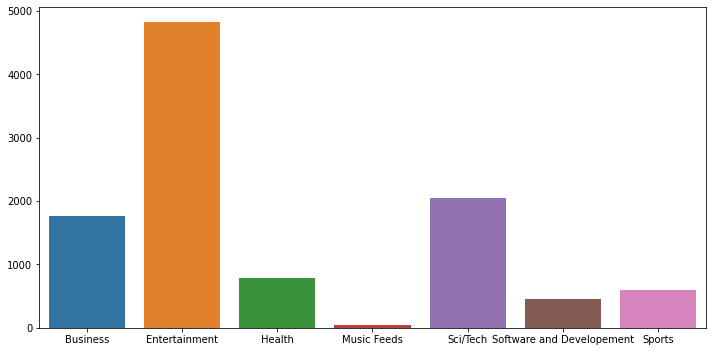

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

value_counts = np.unique(true_labels, return_counts=True)

plt.figure(figsize=(10,5))
sns.barplot(x=value_counts[0], y=value_counts[1])
plt.tight_layout()

In [ ]:
import pandas as pd
frequency_table = pd.DataFrame(value_counts, index=['Label', 'Count']).T
frequency_table['%'] = 100*(frequency_table['Count'] / frequency_table['Count'].sum())
frequency_table = frequency_table.sort_values('%', ascending=False).reset_index(drop=True)
frequency_table

,Label,Count,%
0,Entertainment,4824,45.864233
1,Sci/Tech,2042,19.414337
2,Business,1767,16.799772
3,Health,785,7.463396
4,Sports,601,5.714014
5,Software and Developement,462,4.39247
6,Music Feeds,37,0.351778


In [ ]:
top = frequency_table['Label'][:2].to_list()
top

['Entertainment', 'Sci/Tech']

In [ ]:
valid_idx = []
for i, value in enumerate(Y_augment):
  if value in top:
    valid_idx.append(i)

In [ ]:
import random
from imblearn.over_sampling import SMOTE

# Naively augmenting data by selecting (and incurring annotation cost) for K examples at random.

# In the code snippet below, we show the gain in performance from augmenting data naively
# at a few different budget values (K = 1000, 5000, 10000, 50000)

models_aug_m3 = {}

for K in [1000, 5000, 10000, 50000]:

  idx_random = random.sample(valid_idx, K)

  print("Evaluating for training data size (+augmentation with same data size) = {}".format(K))
  X_train_i = X_train_vectorized + [X_augment_vectorized[i] for i in idx_random]
  Y_train_i = Y_train + [Y_augment[i] for i in idx_random]

  """
  [TO BE IMPLEMENTED]
      
  Paste your pipeline created from Steps 3 or 4 here.
  (You can try both of them out to see what the performance gain is if any)

  e.g. 
  pipeline = Pipeline([
      ('featurizer', <your WordVectorFeaturizer class instance here>),
      ('classifier', <your sklearn classifier class instance here>)
  ])
  """
  pipeline = Pipeline([
          ('classifier', LogisticRegression())
  ])

  sm = SMOTE()

  X_train_i, Y_train_i = sm.fit_resample(X_train_i, Y_train_i)

  # train
  pipeline.fit(X_train_i, Y_train_i)
  # predict
  Y_pred_i = pipeline.predict(X_test_vectorized)
  # record results
  models_aug_m3[K] = {
      'pipeline': pipeline,
      'test_predictions': Y_pred_i,
      'accuracy': accuracy_score(Y_true, Y_pred_i),
      'f1': f1_score(Y_true, Y_pred_i, average='weighted'),
      'errors': sum([x != y for (x, y) in zip(Y_true, Y_pred_i)])
  }
  print("Accuracy on test set: {}".format(accuracy_score(Y_true, Y_pred_i)))

Evaluating for training data size (+augmentation with same data size) = 1000
Accuracy on test set: 0.77866
Evaluating for training data size (+augmentation with same data size) = 5000
Accuracy on test set: 0.77862
Evaluating for training data size (+augmentation with same data size) = 10000
Accuracy on test set: 0.77838
Evaluating for training data size (+augmentation with same data size) = 50000
Accuracy on test set: 0.77774


In [ ]:
print("Pretrained Transformer Models (training data): ")
for train_size, result in models_v2.items():
    print("Train size: {}  |  Accuracy: {}  |  F1 score: {} |  Num errors: {}".format(
        train_size,
        result['accuracy'],
        result['f1'],
        result['errors']
    ))

print("Pretrained Transformer Models (training + standard augmented): ")
for train_size, result in models_aug.items():
    print("Train size: {}  |  Accuracy: {}  |  F1 score: {} |  Num errors: {}".format(
        train_size,
        result['accuracy'],
        result['f1'],
        result['errors']
    ))
    

print("Pretrained Transformer Models (training + selected augmented): ")
for train_size, result in models_aug_m3.items():
    print("Train size: {}  |  Accuracy: {}  |  F1 score: {} |  Num errors: {}".format(
        train_size,
        result['accuracy'],
        result['f1'],
        result['errors']
    ))

Pretrained Transformer Models (training data): 
Train size: 500  |  Accuracy: 0.7246  |  F1 score: 0.7147496655624666 |  Num errors: 13770
Train size: 1000  |  Accuracy: 0.74586  |  F1 score: 0.7374798976544422 |  Num errors: 12707
Train size: 2000  |  Accuracy: 0.76068  |  F1 score: 0.752277187806759 |  Num errors: 11966
Train size: 5000  |  Accuracy: 0.77608  |  F1 score: 0.7696193694789849 |  Num errors: 11196
Train size: 10000  |  Accuracy: 0.78234  |  F1 score: 0.7764766212161883 |  Num errors: 10883
Train size: 25000  |  Accuracy: 0.78964  |  F1 score: 0.7837853103810741 |  Num errors: 10518
Pretrained Transformer Models (training + standard augmented): 
Train size: 1000  |  Accuracy: 0.78964  |  F1 score: 0.7838052594426547 |  Num errors: 10518
Train size: 5000  |  Accuracy: 0.79066  |  F1 score: 0.7849096802943021 |  Num errors: 10467
Train size: 10000  |  Accuracy: 0.79096  |  F1 score: 0.7851777954300094 |  Num errors: 10452
Train size: 50000  |  Accuracy: 0.79586  |  F1 scor

### Method 1

Train a Nearest Neighbors in the augmented data and verify which samples from augmentation dataset are similar to the test_set.

In [ ]:
from sklearn.neighbors import NearestNeighbors
import random

models_v3 = {}

test_errors_array = [error[0] for error in test_errors_v2]
test_errors_array_vectorized = TransformerFeaturizer(None, sentence_transformer_model).transform(test_errors_array)

for n in [1,2,3,4,5]:

  test_errors_array = [error[0] for error in test_errors_v2]

  # Find N elements most similar to each test_errors
  topn = n
  nn = NearestNeighbors(n_neighbors=topn)
  nn.fit(X_augment_vectorized)  

  most_similar = nn.kneighbors(test_errors_array_vectorized)[1].flatten()
  most_similar_samples_idx = list(set(most_similar))

  X_augment_i = [X_augment_vectorized[i] for i in most_similar_samples_idx]
  Y_augment_i = [Y_augment[i] for i in most_similar_samples_idx]


  K = len(X_augment_i)

  print("Evaluating for training data size {} + augmented = {}".format(len(X_train_vectorized), K))
  X_train_i = X_train_vectorized + X_augment_i
  Y_train_i = Y_train + Y_augment_i



  """
  [TO BE IMPLEMENTED]
      
  Goal: initialized below is a dummy sklearn Pipeline object with no steps.
  You have to replace it with a pipeline object which contains at least two steps:
  (1) mapping the input document to a feature vector (using TransformerFeaturizer)
  (2) a classifier that predicts the class label using the feature output of first step

  You can add other steps to preproces, post-process your data as you see fit. 
  You can also try any sklearn model architecture you want, but a linear classifier
  will do just fine to start with

  e.g. 
  pipeline = Pipeline([
      ('featurizer', <your TransformerFeaturizer class instance here>),
      ('classifier', <your sklearn classifier class instance here>)
  ])
  """
  pipeline = Pipeline([
      ('classifier', LogisticRegression())
  ])

  # train
  pipeline.fit(X_train_i, Y_train_i)
  # predict
  Y_pred_i = pipeline.predict(X_test_vectorized)
  # record results
  models_v3[K] = {
      'pipeline': pipeline,
      'test_predictions': Y_pred_i,
      'accuracy': accuracy_score(Y_true, Y_pred_i),
      'f1': f1_score(Y_true, Y_pred_i, average='weighted'),
      'errors': sum([x != y for (x, y) in zip(Y_true, Y_pred_i)])
  }
  print("Accuracy on test set: {}".format(accuracy_score(Y_true, Y_pred_i)))

Evaluating for training data size 25000 + augmented = 9274
Accuracy on test set: 0.7964
Evaluating for training data size 25000 + augmented = 17272
Accuracy on test set: 0.79714
Evaluating for training data size 25000 + augmented = 24227
Accuracy on test set: 0.79748
Evaluating for training data size 25000 + augmented = 30473
Accuracy on test set: 0.79696
Evaluating for training data size 25000 + augmented = 35903
Accuracy on test set: 0.79746


In [ ]:
# Report results

print("Word Vector Models: ")
for train_size, result in models.items():
    print("Train size: {}  |  Accuracy: {}  |  F1 score: {} |  Num errors: {}".format(
        train_size,
        result['accuracy'],
        result['f1'],
        result['errors']
    ))

print("Pretrained Transformer Models: ")
for train_size, result in models_v2.items():
    print("Train size: {}  |  Accuracy: {}  |  F1 score: {} |  Num errors: {}".format(
        train_size,
        result['accuracy'],
        result['f1'],
        result['errors']
    ))

print("Pretrained Transformer Models (training + random augmented): ")
for train_size, result in models_aug.items():
    print("Train size: {}  |  Accuracy: {}  |  F1 score: {} |  Num errors: {}".format(
        train_size,
        result['accuracy'],
        result['f1'],
        result['errors']
    ))

print("Pretrained Transformer Models (training + selected augmented): ")
for train_size, result in models_aug_m3.items():
    print("Train size: {}  |  Accuracy: {}  |  F1 score: {} |  Num errors: {}".format(
        train_size,
        result['accuracy'],
        result['f1'],
        result['errors']
    ))

print("Pretrained Transformer Models + Augmented selected samples: ")
for train_size, result in models_v3.items():
    print("Train size: {}  |  Accuracy: {}  |  F1 score: {} |  Num errors: {}".format(
        train_size,
        result['accuracy'],
        result['f1'],
        result['errors']
    ))

Word Vector Models: 
Train size: 500  |  Accuracy: 0.71226  |  F1 score: 0.7073686468379936 |  Num errors: 14387
Train size: 1000  |  Accuracy: 0.72694  |  F1 score: 0.7207984998317425 |  Num errors: 13653
Train size: 2000  |  Accuracy: 0.73686  |  F1 score: 0.7313847575524624 |  Num errors: 13157
Train size: 5000  |  Accuracy: 0.74576  |  F1 score: 0.7414484789905316 |  Num errors: 12712
Train size: 10000  |  Accuracy: 0.7503  |  F1 score: 0.7461294127796578 |  Num errors: 12485
Train size: 25000  |  Accuracy: 0.75274  |  F1 score: 0.7483787965589375 |  Num errors: 12363
Pretrained Transformer Models: 
Train size: 500  |  Accuracy: 0.7246  |  F1 score: 0.7147496655624666 |  Num errors: 13770
Train size: 1000  |  Accuracy: 0.74586  |  F1 score: 0.7374798976544422 |  Num errors: 12707
Train size: 2000  |  Accuracy: 0.76068  |  F1 score: 0.752277187806759 |  Num errors: 11966
Train size: 5000  |  Accuracy: 0.77608  |  F1 score: 0.7696193694789849 |  Num errors: 11196
Train size: 10000  |

In [ ]:
# For the augmentation methods i added SMOTE to balance the dataset (because with a additional of new classes maybe it can be imbalanced).
# I got better results using the selected samples (with Nearest Neighbors approach).
# For example, comparing the random augmented approach, we got the best result with addition of 50000 samples:
# Train size: 50000  |  Accuracy: 0.79586  |  F1 score: 0.7905457086648299 |  Num errors: 10207
# And the NEAREST NEIGHBORS returned a better value using just 9274 samples!
# Train size: 9274  |  Accuracy: 0.7964  |  F1 score: 0.7905258629082256 |  Num errors: 10179